In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

In [5]:
def fetch_data(companies, tenure=1):
  '''
  companies -> list of companies for which you want the model to train
  tenure -> count of years of data
  '''
  end = datetime.now()
  start = datetime(end.year-tenure, end.month, end.day)
  data = {}
  for company in companies:
    df = yf.download(company, start, end)
    data[company] = df['Close']
  return pd.DataFrame(data)

In [20]:
def preprocess_data(data, window_size=60):
  X, Y = [], []
  scalers = {}

  for company in data.columns:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[[company]])
    scalers[company] = scaler

    for i in range(window_size, len(scaled_data)):
      X.append(scaled_data[i-window_size: i])
      Y.append(scaled_data[i])

  return np.asarray(X), np.asarray(Y), scalers

In [96]:
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_features = 1):
  model = Sequential()
  model.add(LSTM(units=50, activation='relu', input_shape=(window_size, num_features)))
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
  return model

In [36]:
# 4. Generate predictions
def make_predictions(model, data, scalers, window_size):
    predictions = []

    for i, company in enumerate(data.columns):
        scaler = scalers[company]
        scaled_data = scaler.transform(data[[company]])
        X, _, _ = preprocess_data(pd.DataFrame(scaled_data), window_size)
        company_predictions = model.predict(X)
        company_predictions = scaler.inverse_transform(company_predictions)
        predictions.append(company_predictions)

    return np.array(predictions).T  # Transpose to match original data shape

In [131]:
def plot_results(original_data, predictions, sequence_length, company):
    # Ensure original_data is a DataFrame and has the correct index
    if not isinstance(original_data, pd.DataFrame):
        raise ValueError("original_data must be a DataFrame.")

    # Generate dates for x-axis
    dates = original_data.index[sequence_length:]

    # Extract actual prices
    actual_prices = original_data.values[sequence_length:]

    # Ensure both actual and predicted prices are aligned
    min_length = min(len(actual_prices), len(predictions))
    dates = dates[:min_length]
    actual_prices = actual_prices[:min_length]
    predictions = predictions[:min_length]

    plt.figure(figsize=(15, 6))

    plt.plot(dates, actual_prices, label='Actual Prices', color='blue')
    plt.plot(dates, predictions, label='Predicted Prices', color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f"Actual vs Predicted Stock Prices {company}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

In [13]:
companies = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'IBM', 'ORCL',
    'INTC', 'CSCO', 'AMD', 'BA', 'WMT', 'DIS', 'MCD', 'PYPL', 'NKE', 'BABA',
    'ADBE', 'CRM', 'TSM', 'UBER', 'PFE', 'GILD', 'CVX', 'XOM', 'MA', 'V', 'WFC'
]
data = fetch_data(companies, 1)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,AAPL,MSFT,GOOGL,AMZN,TSLA,META,NFLX,NVDA,IBM,ORCL,...,CRM,TSM,UBER,PFE,GILD,CVX,XOM,MA,V,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-12,176.300003,331.769989,135.339996,141.229996,267.480011,301.660004,434.690002,44.869999,146.300003,109.610001,...,221.660004,90.480003,47.919998,34.150002,76.800003,166.809998,117.489998,416.269989,247.300003,42.540001
2023-09-13,174.210007,336.059998,136.710007,144.850006,271.299988,305.059998,412.239990,45.485001,146.550003,111.839996,...,218.800003,91.220001,48.160000,34.080002,77.309998,166.199997,116.440002,416.299988,247.830002,42.250000
2023-09-14,175.740005,338.700012,138.100006,144.720001,276.040009,311.720001,400.489990,45.581001,147.350006,113.660004,...,218.779999,91.470001,48.320000,34.150002,77.360001,167.229996,118.519997,413.339996,241.500000,43.049999
2023-09-15,175.009995,330.220001,137.399994,140.389999,274.390015,300.309998,396.940002,43.900002,145.990005,113.910004,...,214.610001,89.250000,47.520000,34.070000,75.669998,166.500000,116.699997,414.309998,241.070007,42.950001
2023-09-18,177.970001,329.059998,138.210007,139.979996,265.279999,302.549988,394.399994,43.966000,145.089996,112.209999,...,215.000000,88.830002,46.509998,33.639999,75.620003,167.220001,117.639999,417.130005,244.660004,43.430000


In [15]:
data.shape

(252, 31)

In [22]:
window_size = 60
X, Y, scalers = preprocess_data(data, window_size)

In [97]:
model = build_model((X.shape[1], X.shape[2]))
history = model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0818 - val_loss: 0.0069
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 12/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 

In [113]:
predictions = make_predictions(model, data, scalers, window_size)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━

In [114]:
# 6. Calculate and print the accuracy using Mean Absolute Error (MAE)
mae = np.mean(np.abs(predictions - data.iloc[window_size:].values))
print(f'Mean Absolute Error (MAE): {mae:.4f}')

Mean Absolute Error (MAE): 2.7980


In [121]:
predictions = predictions[0]
predictions

array([[192.78853 , 371.38492 , 131.02454 , ..., 407.76895 , 254.11592 ,
         44.26955 ],
       [191.63362 , 367.6252  , 130.02855 , ..., 409.33478 , 253.76294 ,
         44.30053 ],
       [193.59026 , 369.78806 , 137.16106 , ..., 411.9874  , 255.23158 ,
         45.200836],
       ...,
       [219.01172 , 399.73276 , 150.24185 , ..., 472.65244 , 278.20422 ,
         53.699234],
       [219.28696 , 403.7235  , 148.18352 , ..., 482.8924  , 283.8816  ,
         54.290257],
       [218.48268 , 411.54767 , 148.07503 , ..., 482.80627 , 283.33136 ,
         53.51921 ]], dtype=float32)

In [138]:
pd.DataFrame(predictions)[companies.index('AAPL')]

,0
0,192.788528
1,191.633621
2,193.590256
3,194.943588
4,192.534149
...,...
187,219.397430
188,220.704666
189,219.011719
190,219.286957


In [123]:
(predictions.shape, pd.DataFrame(predictions)[companies.index(specific_company)].shape)

((192, 31), (192,))

In [137]:
from sklearn.metrics import mean_absolute_error

for company in companies:
  actual_prices = data[company].values[window_size:]
  predicted_prices = pd.DataFrame(predictions)[companies.index(company)]

  mae = mean_absolute_error(actual_prices, predicted_prices)
  print(f'Mean Absolute Error [{company}]:\t {mae:.4f}')

Mean Absolute Error [AAPL]:	 2.2879
Mean Absolute Error [MSFT]:	 4.6419
Mean Absolute Error [GOOGL]:	 2.2006
Mean Absolute Error [AMZN]:	 2.5979
Mean Absolute Error [TSLA]:	 5.5046
Mean Absolute Error [META]:	 8.7722
Mean Absolute Error [NFLX]:	 10.4942
Mean Absolute Error [NVDA]:	 2.8578
Mean Absolute Error [IBM]:	 2.0302
Mean Absolute Error [ORCL]:	 1.7485
Mean Absolute Error [INTC]:	 0.8617
Mean Absolute Error [CSCO]:	 0.3973
Mean Absolute Error [AMD]:	 4.0606
Mean Absolute Error [BA]:	 3.1834
Mean Absolute Error [WMT]:	 0.5969
Mean Absolute Error [DIS]:	 1.2163
Mean Absolute Error [MCD]:	 2.4080
Mean Absolute Error [PYPL]:	 1.0582
Mean Absolute Error [NKE]:	 1.3181
Mean Absolute Error [BABA]:	 1.2234
Mean Absolute Error [ADBE]:	 7.7830
Mean Absolute Error [CRM]:	 4.1084
Mean Absolute Error [TSM]:	 3.1208
Mean Absolute Error [UBER]:	 1.2823
Mean Absolute Error [PFE]:	 0.3184
Mean Absolute Error [GILD]:	 0.8324
Mean Absolute Error [CVX]:	 1.4335
Mean Absolute Error [XOM]:	 1.1229
Mea

In [139]:
model.save('stock_price_prediction_model.h5')

<Figure size 2000x1000 with 0 Axes>

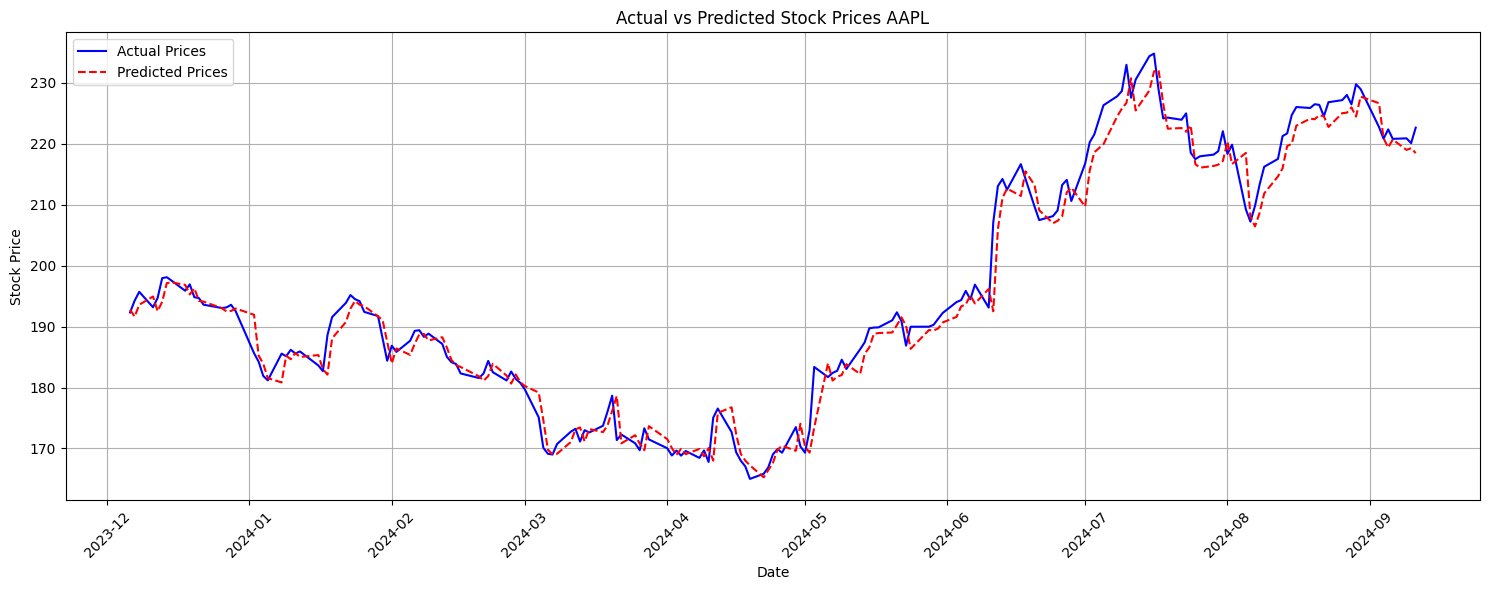

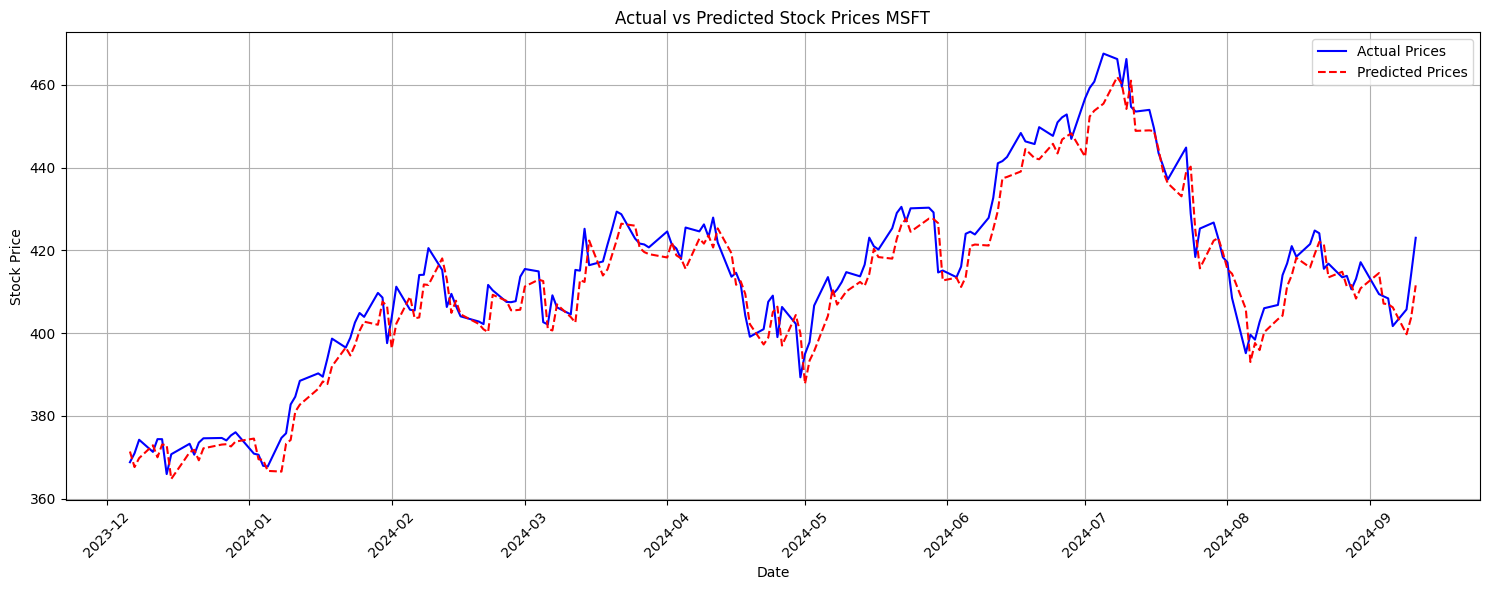

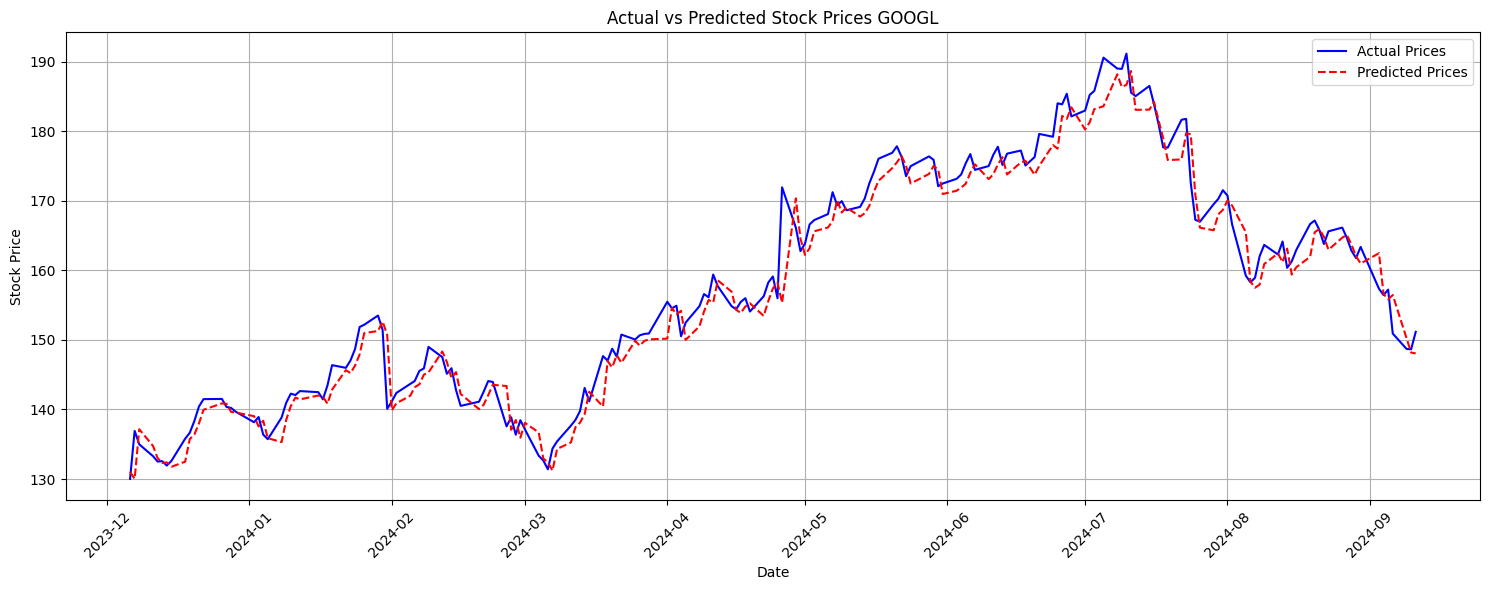

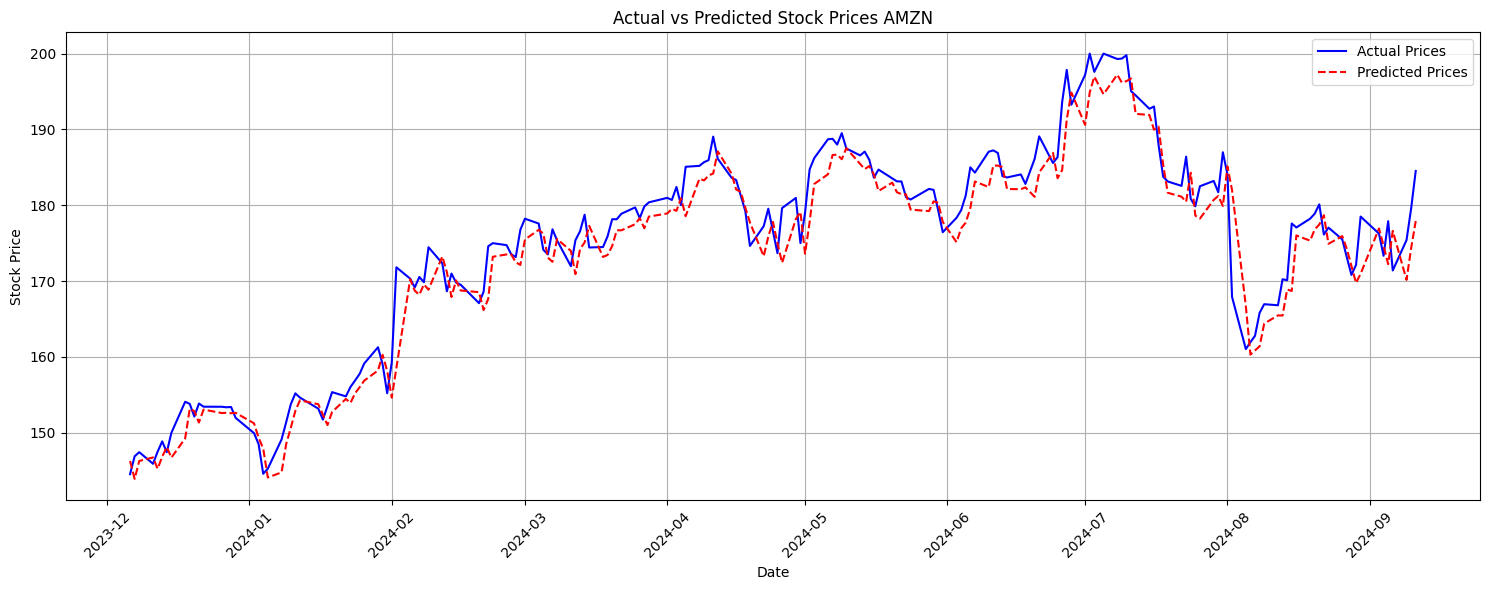

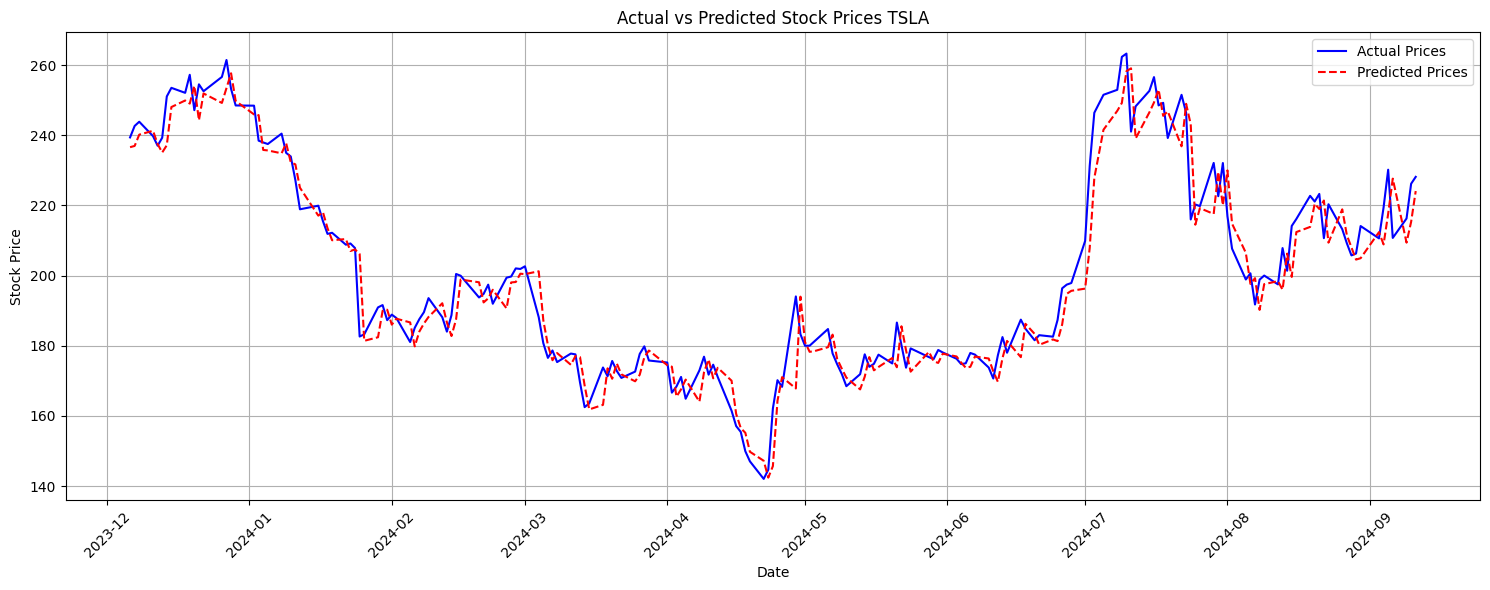

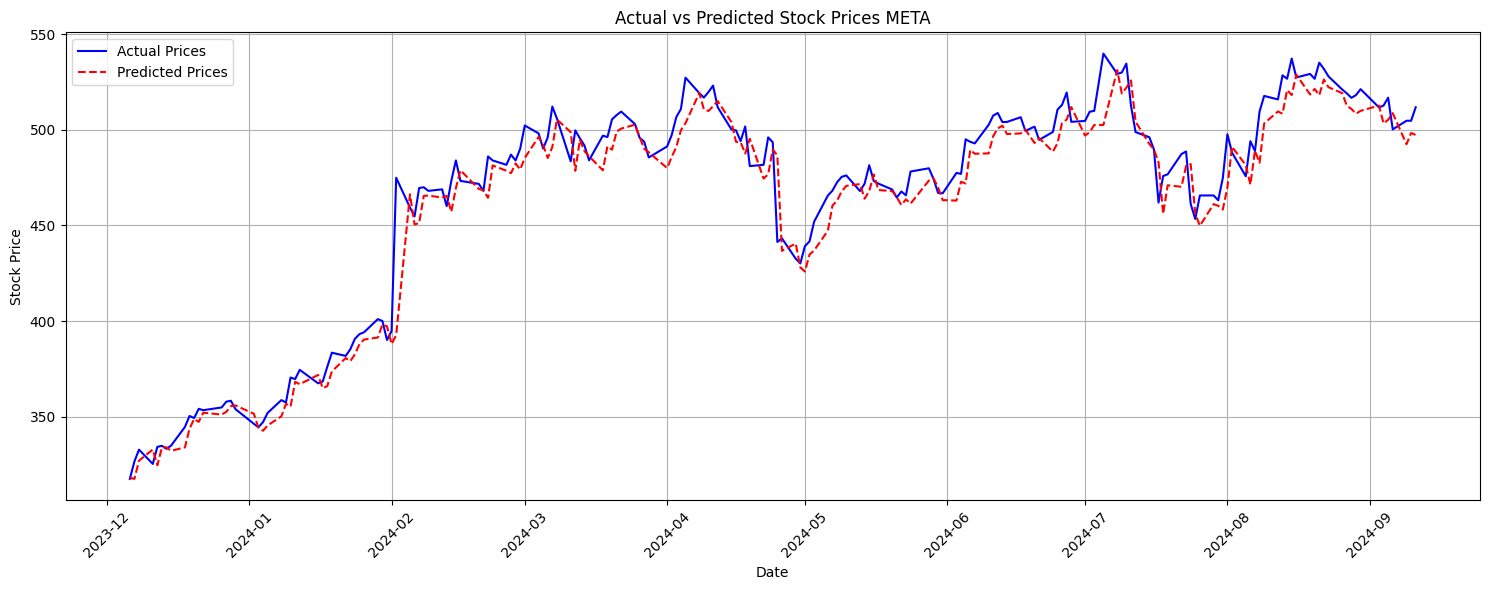

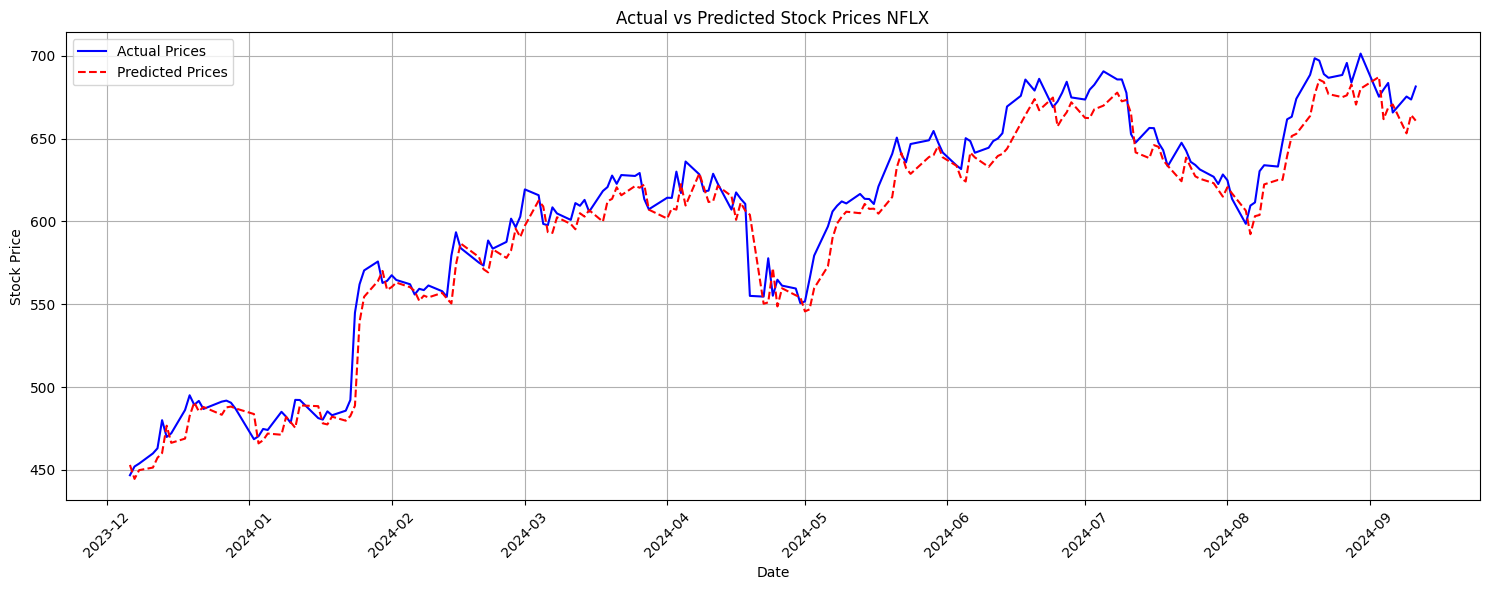

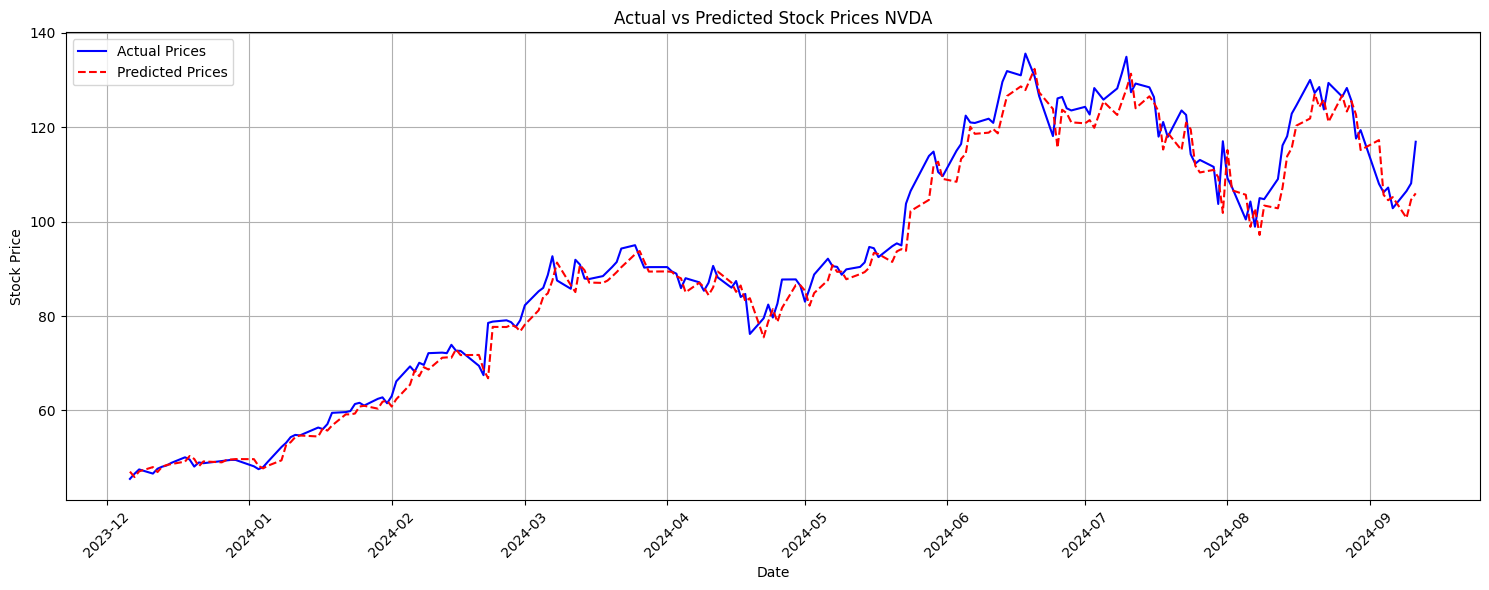

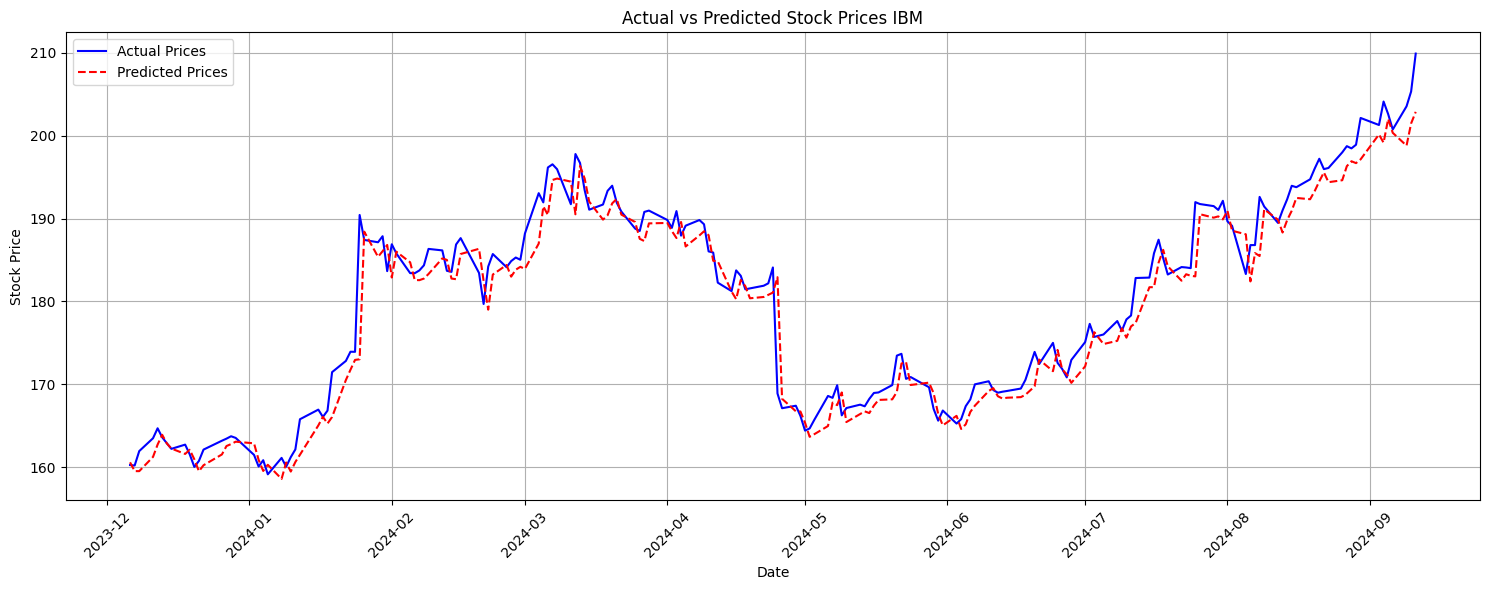

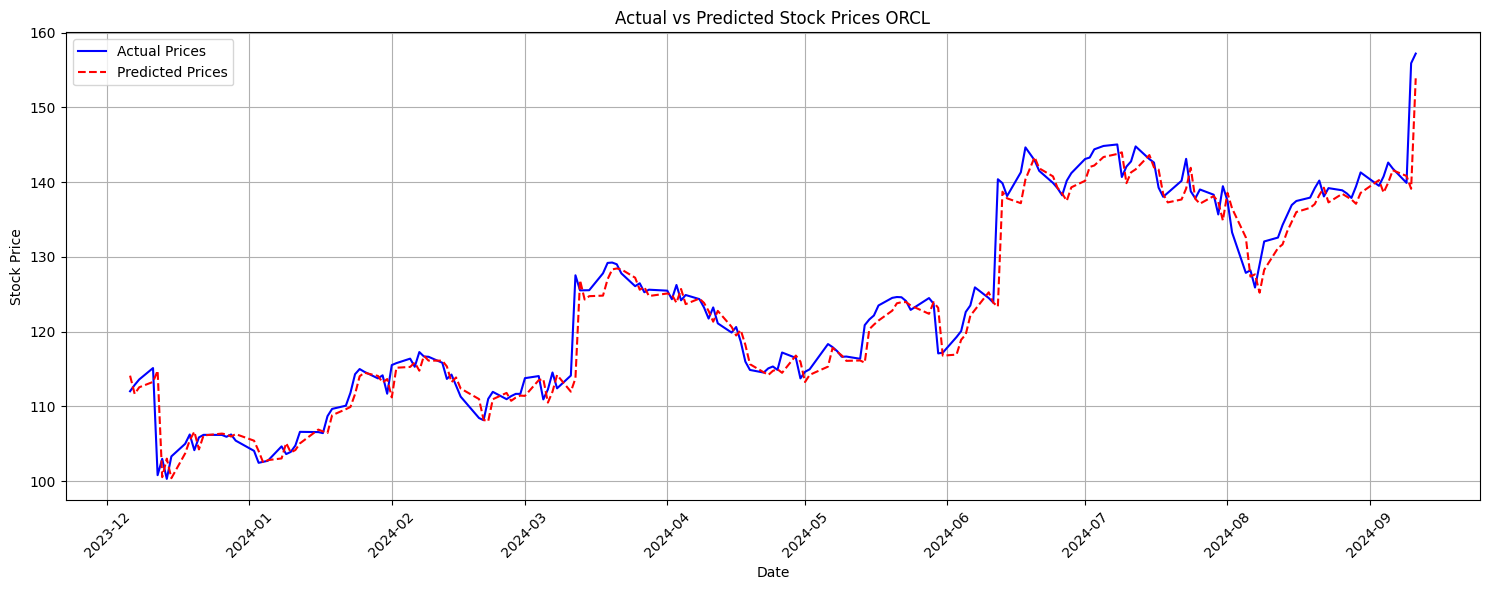

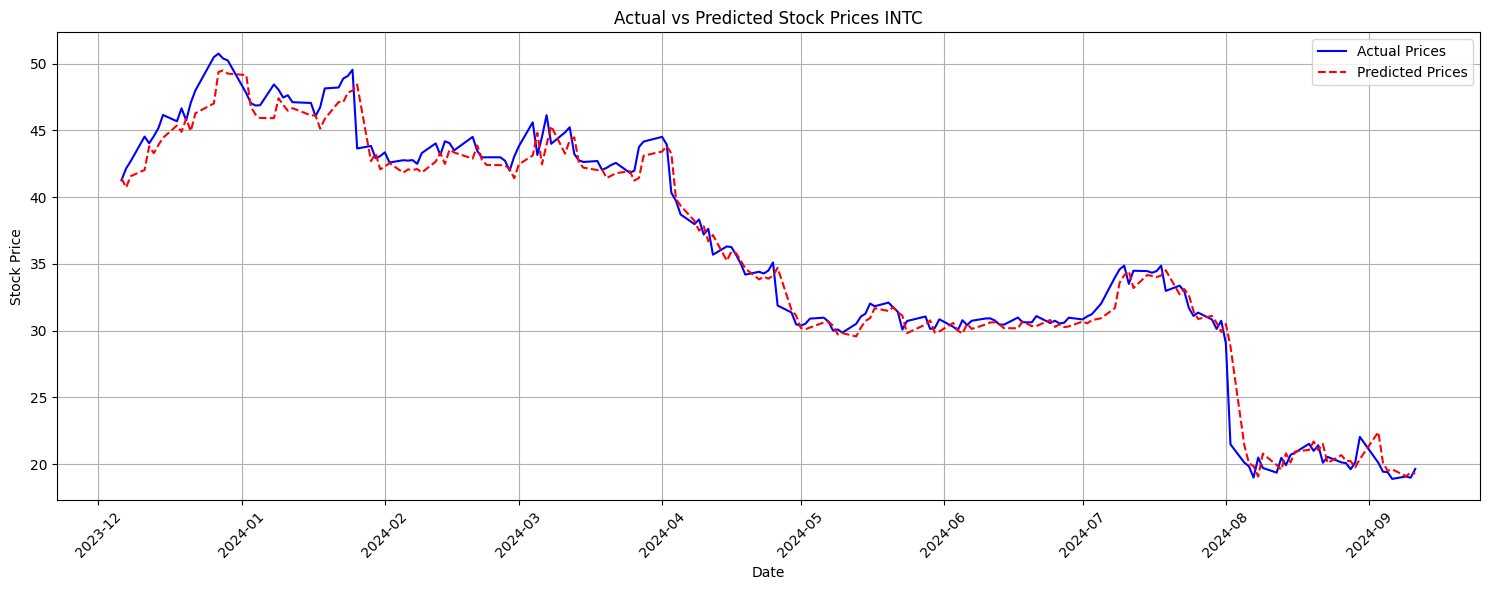

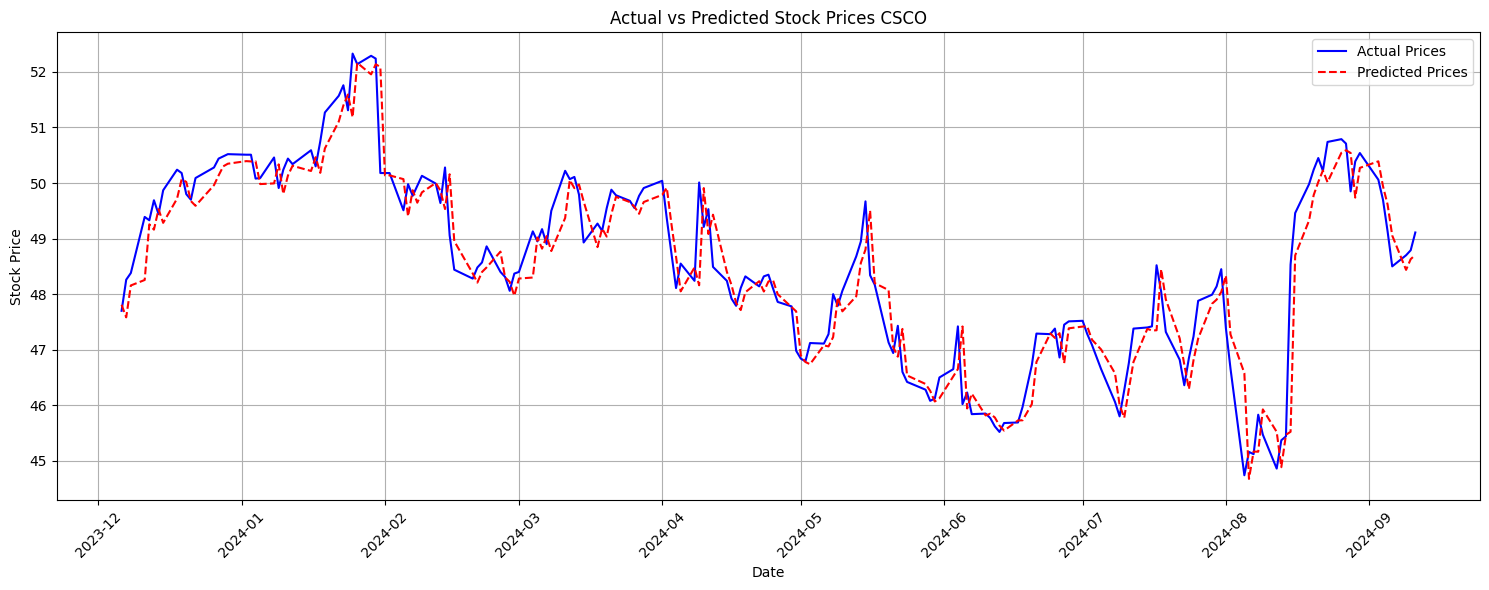

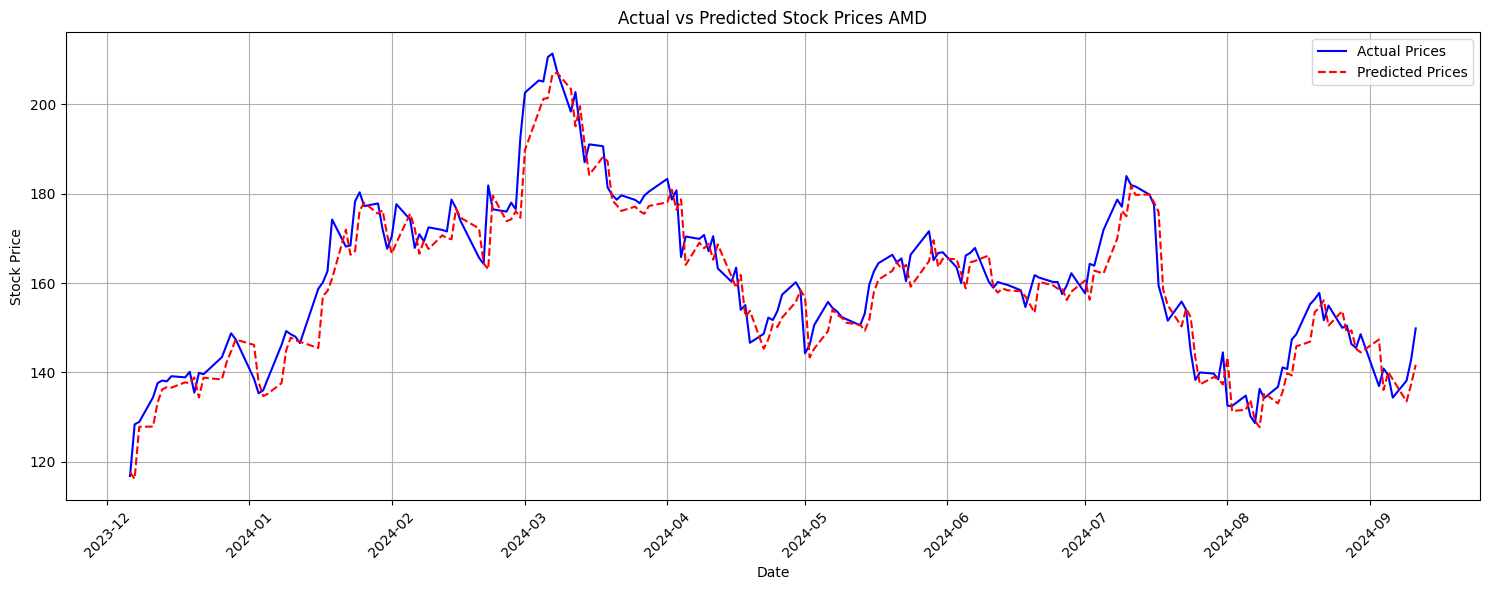

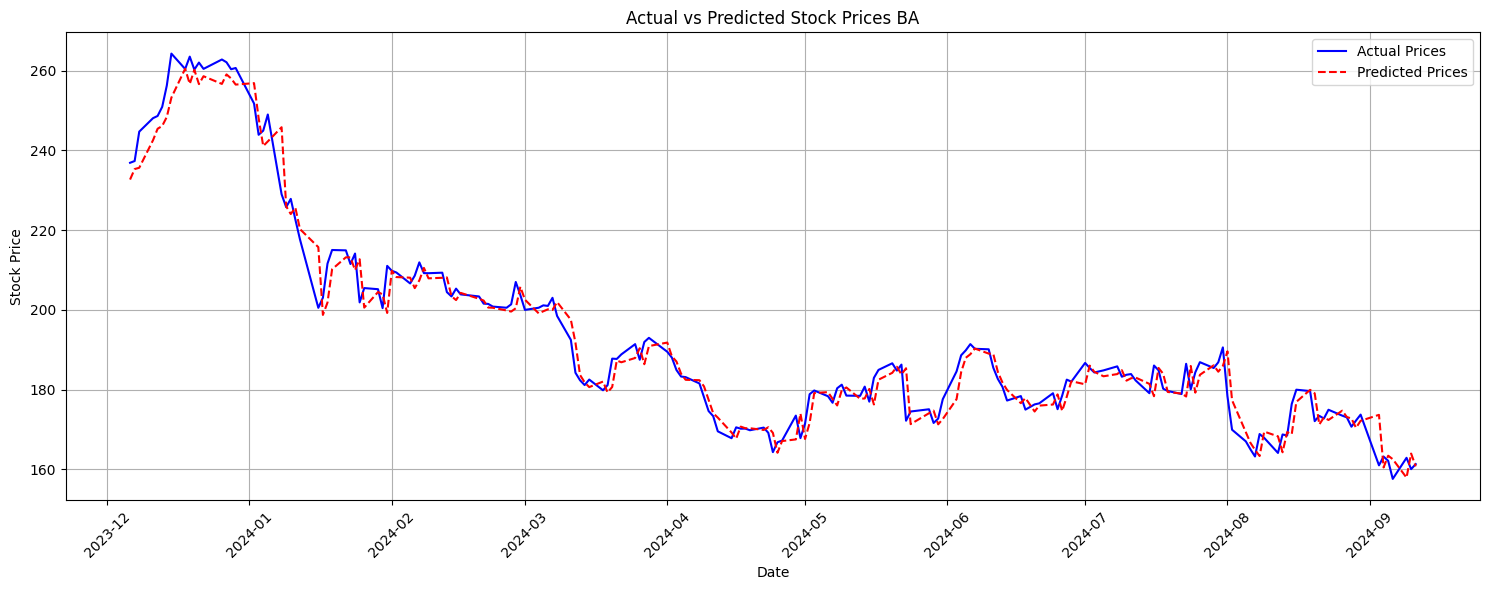

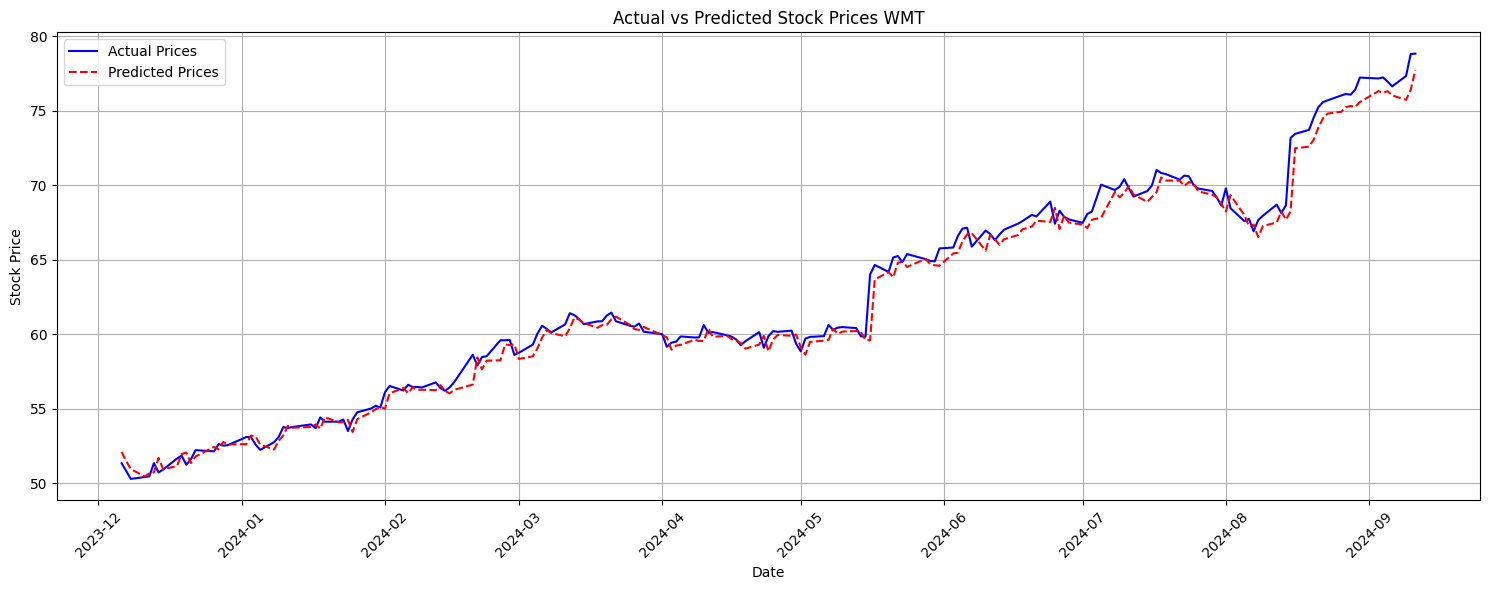

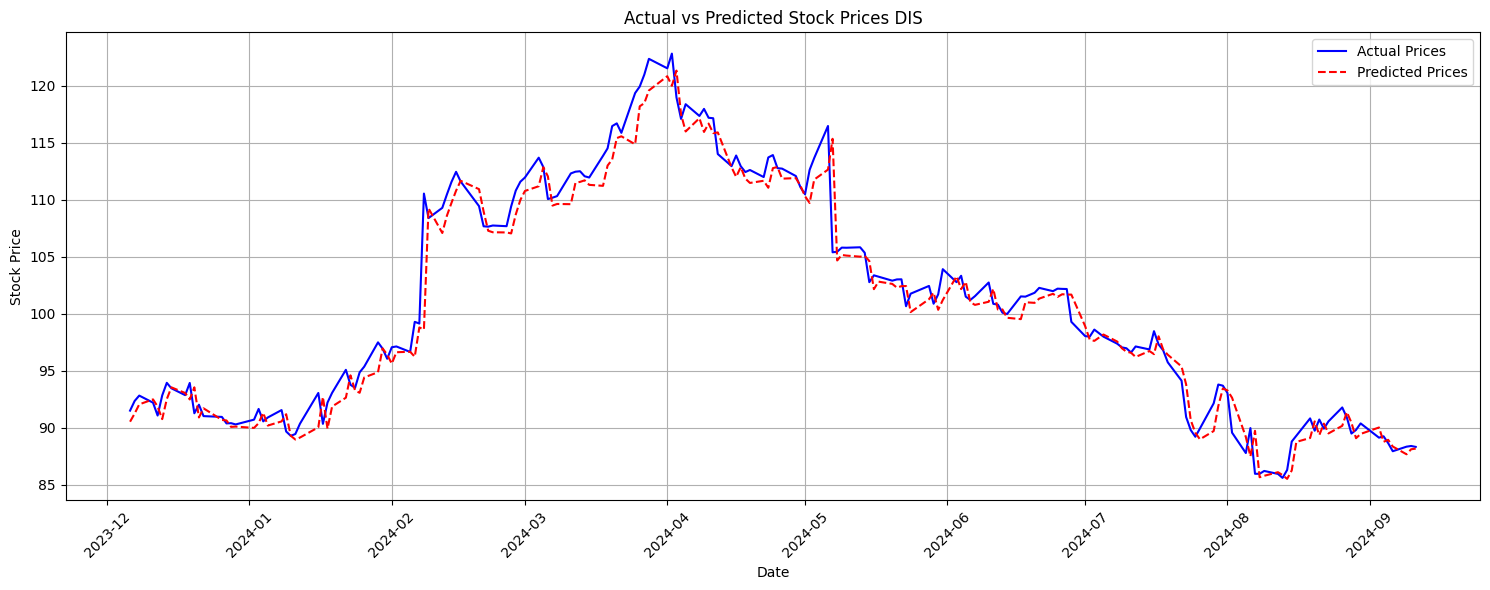

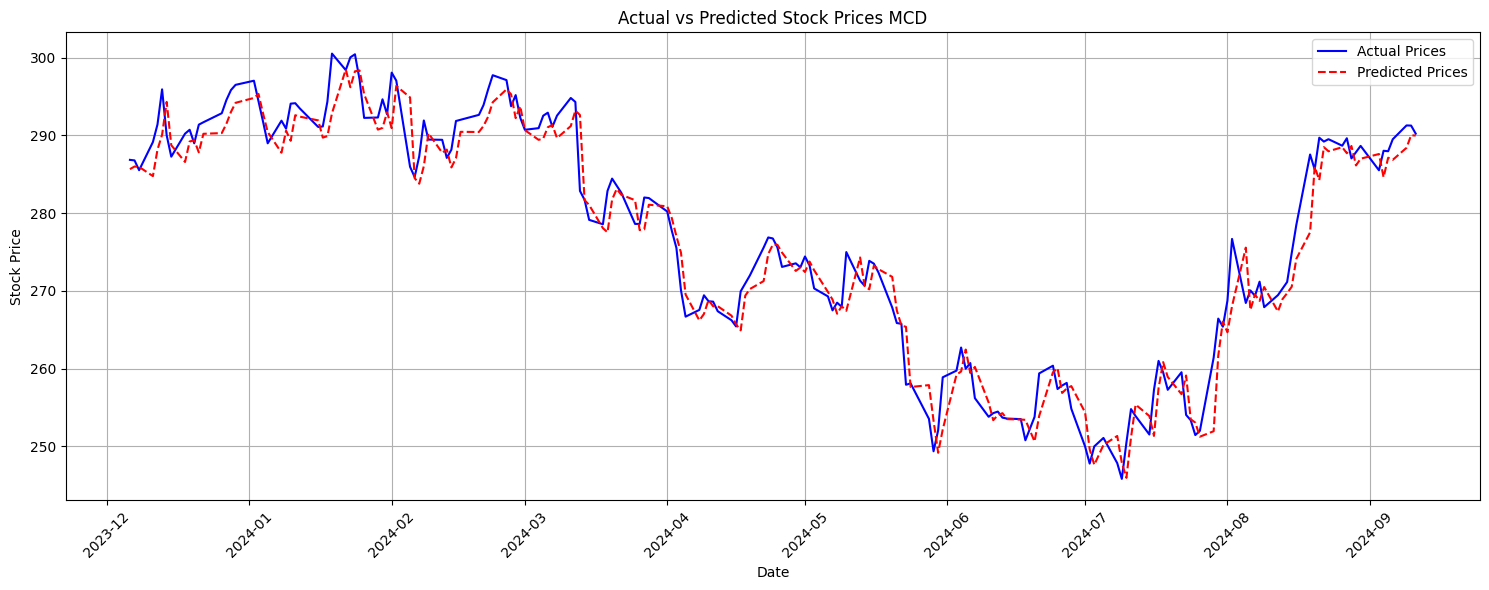

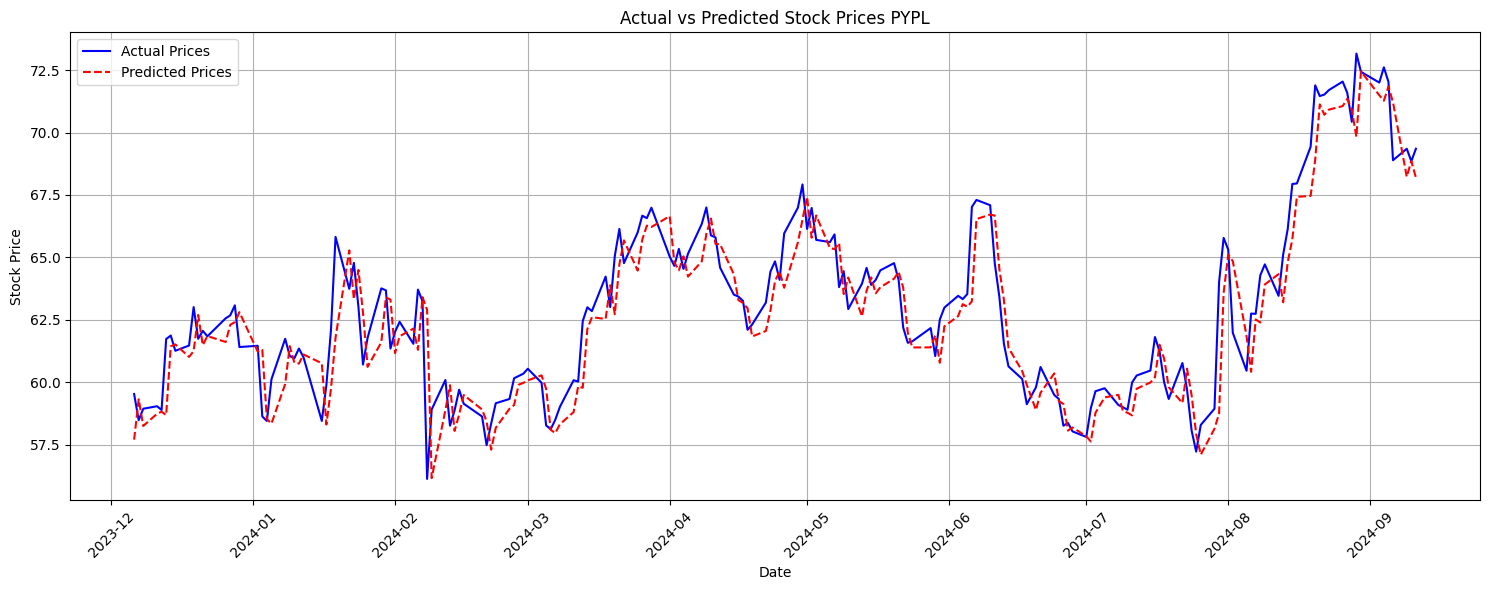

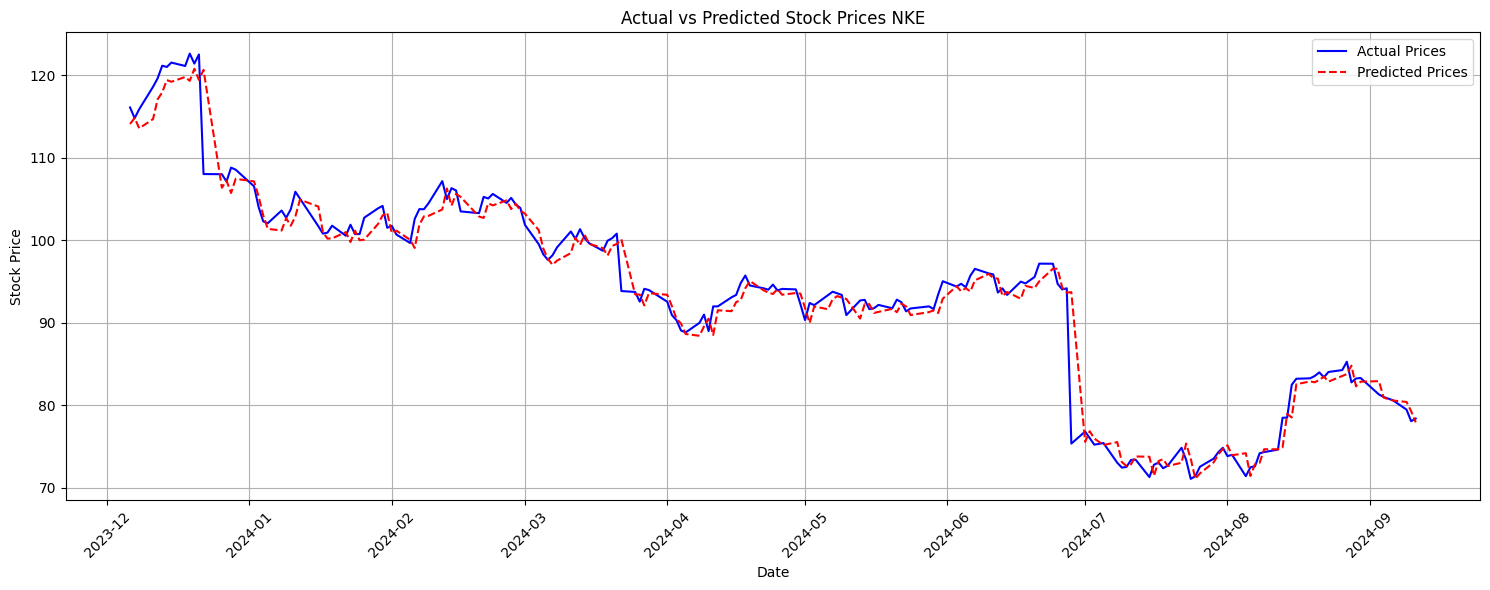

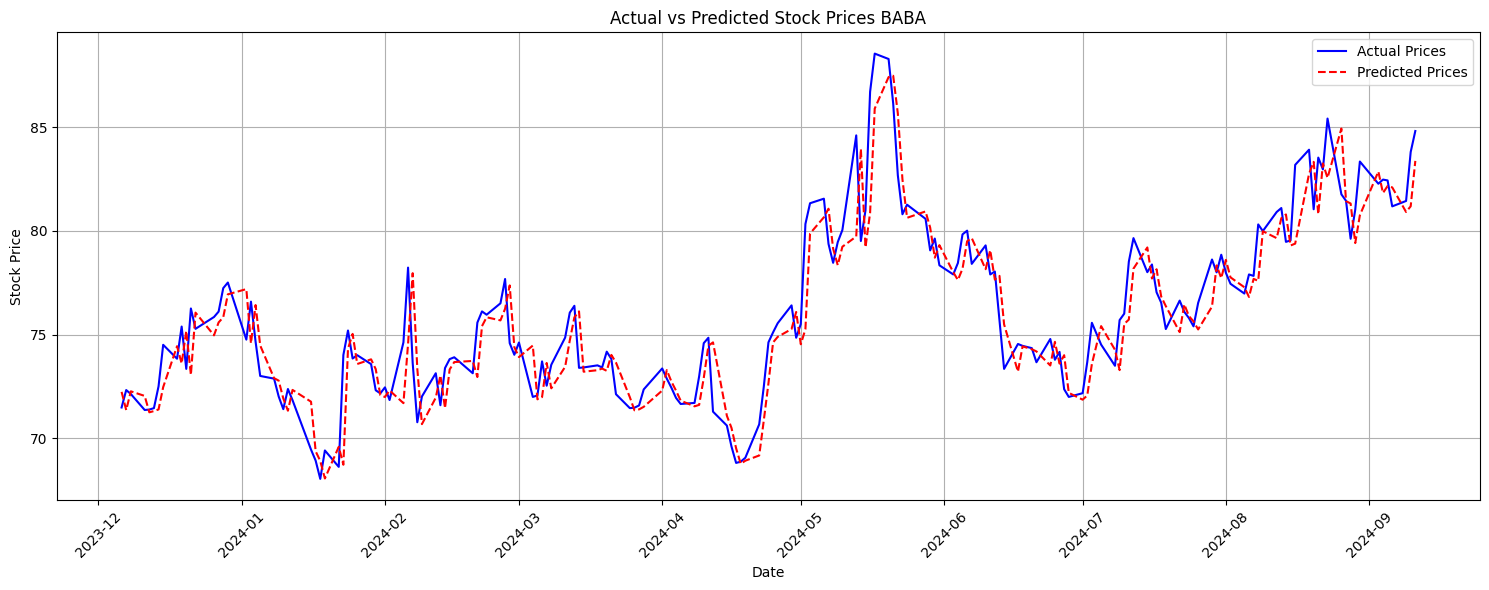

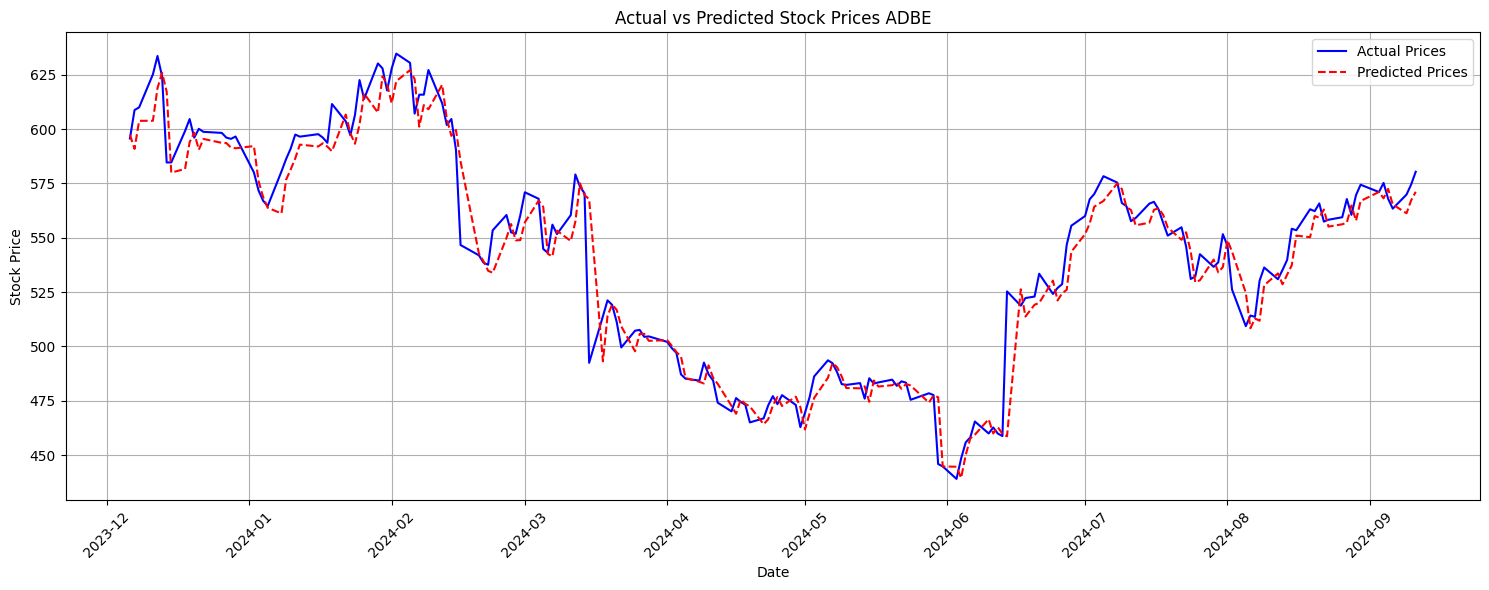

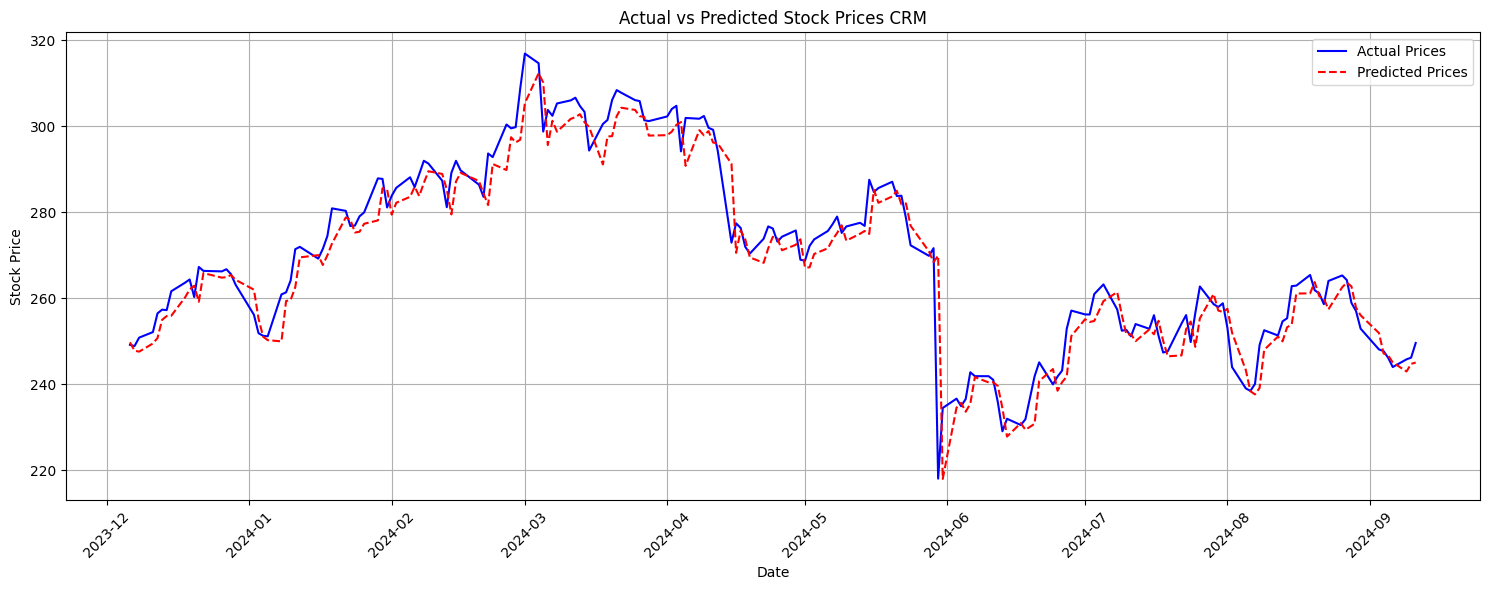

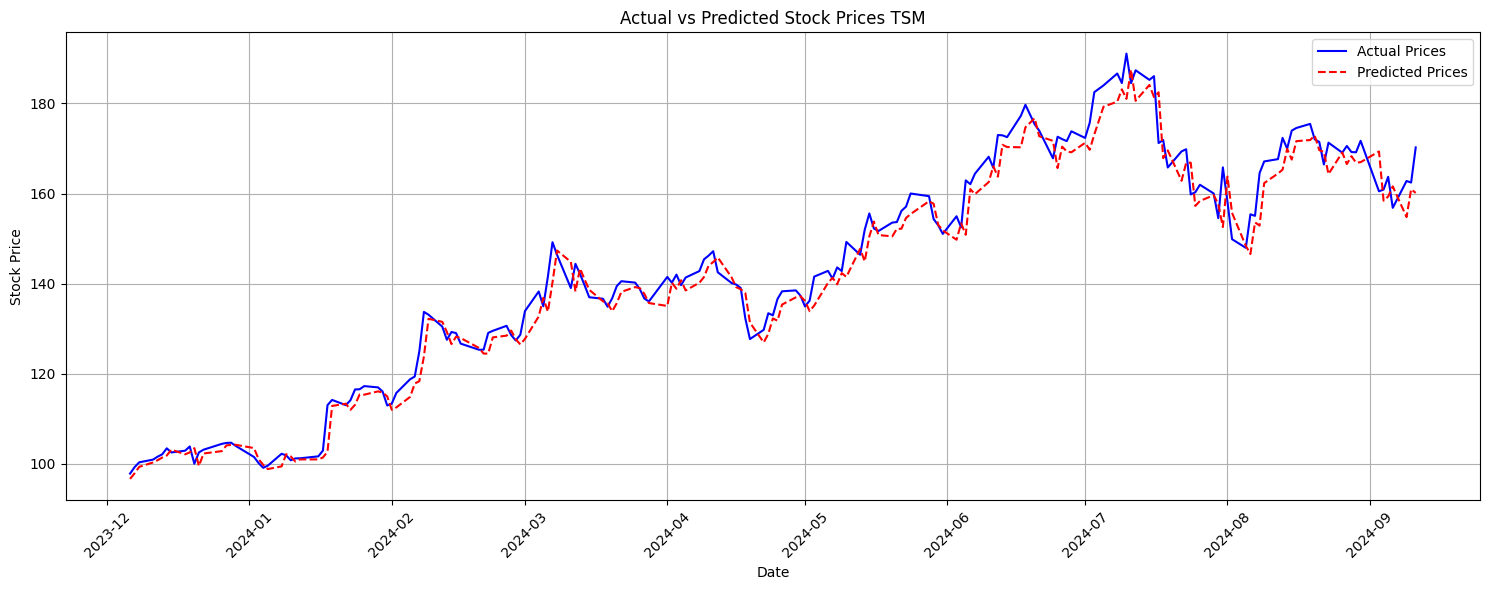

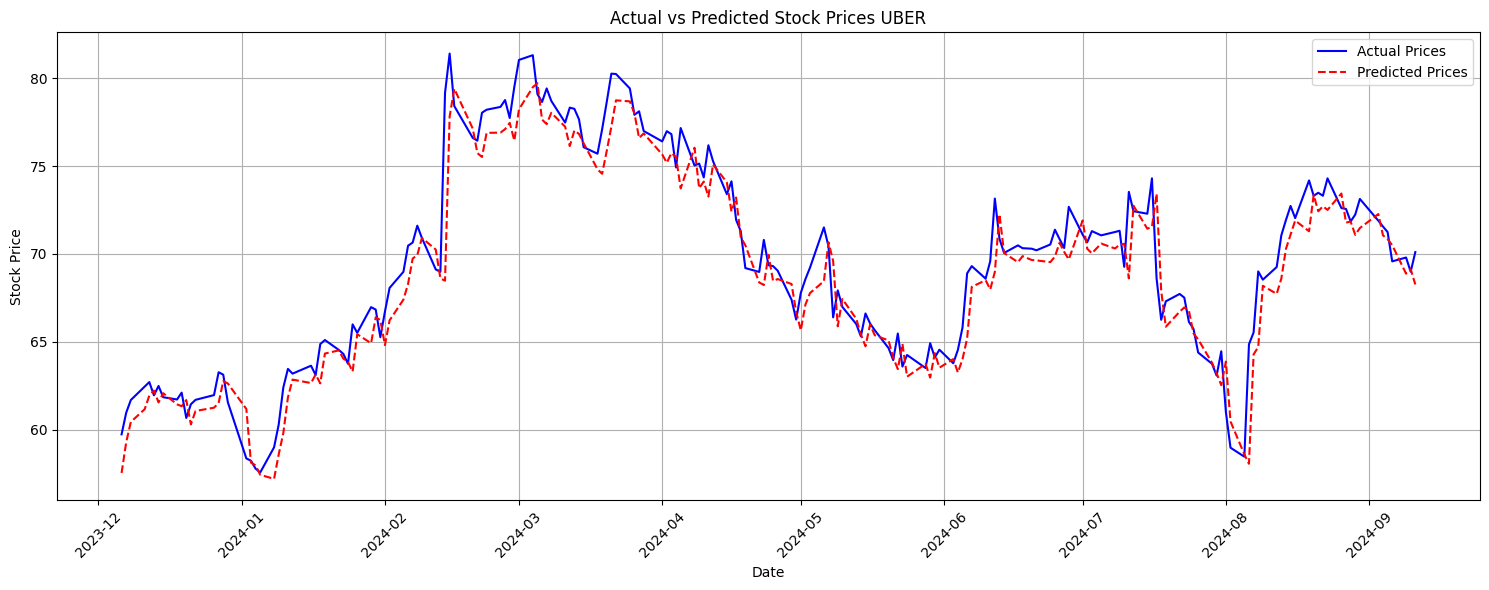

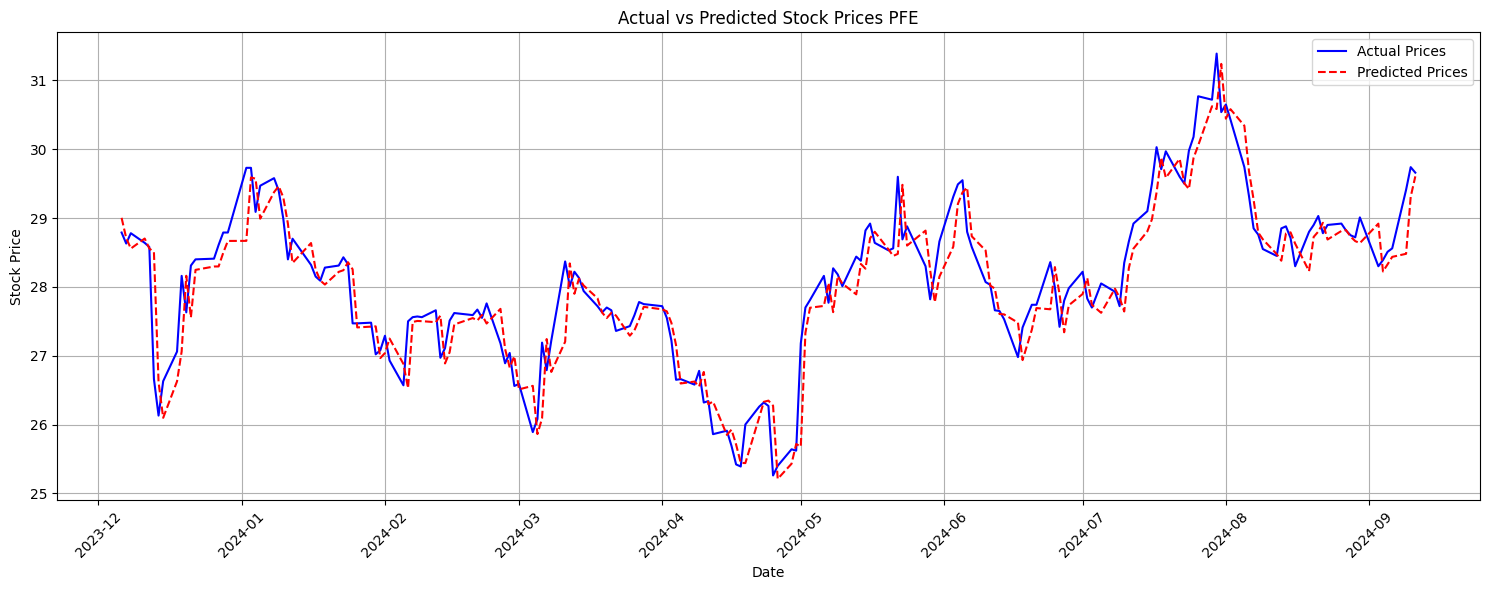

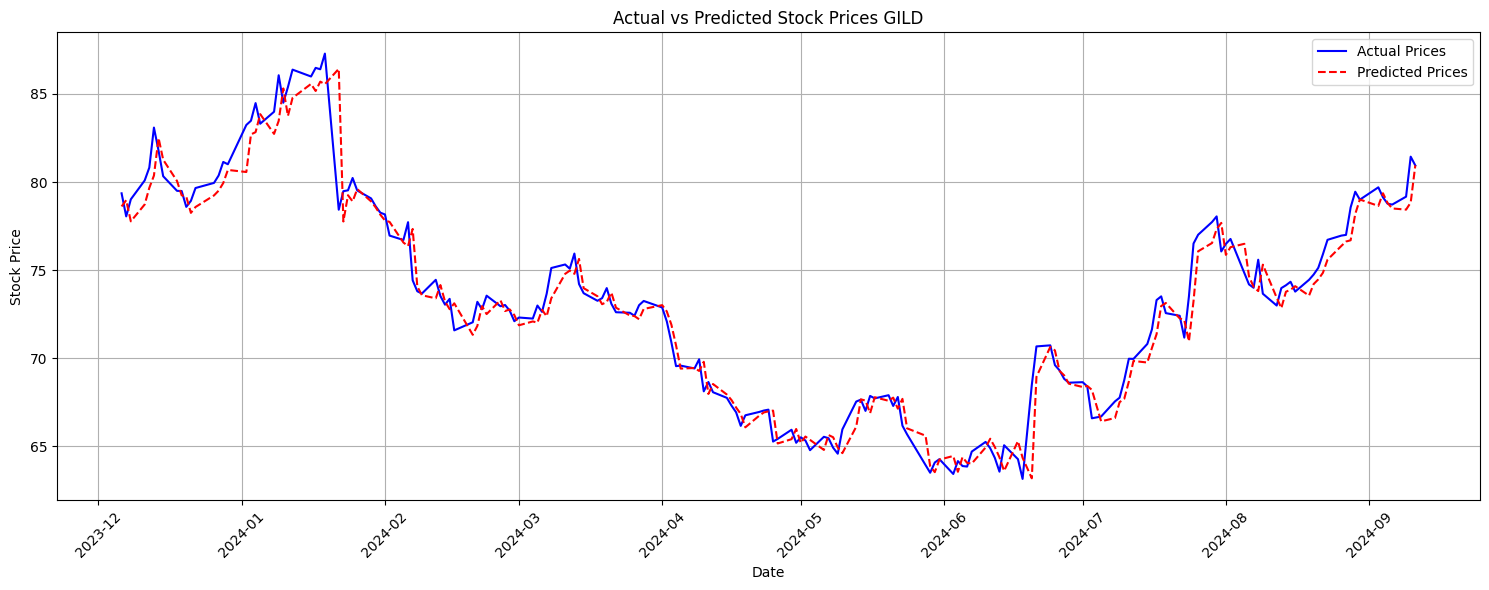

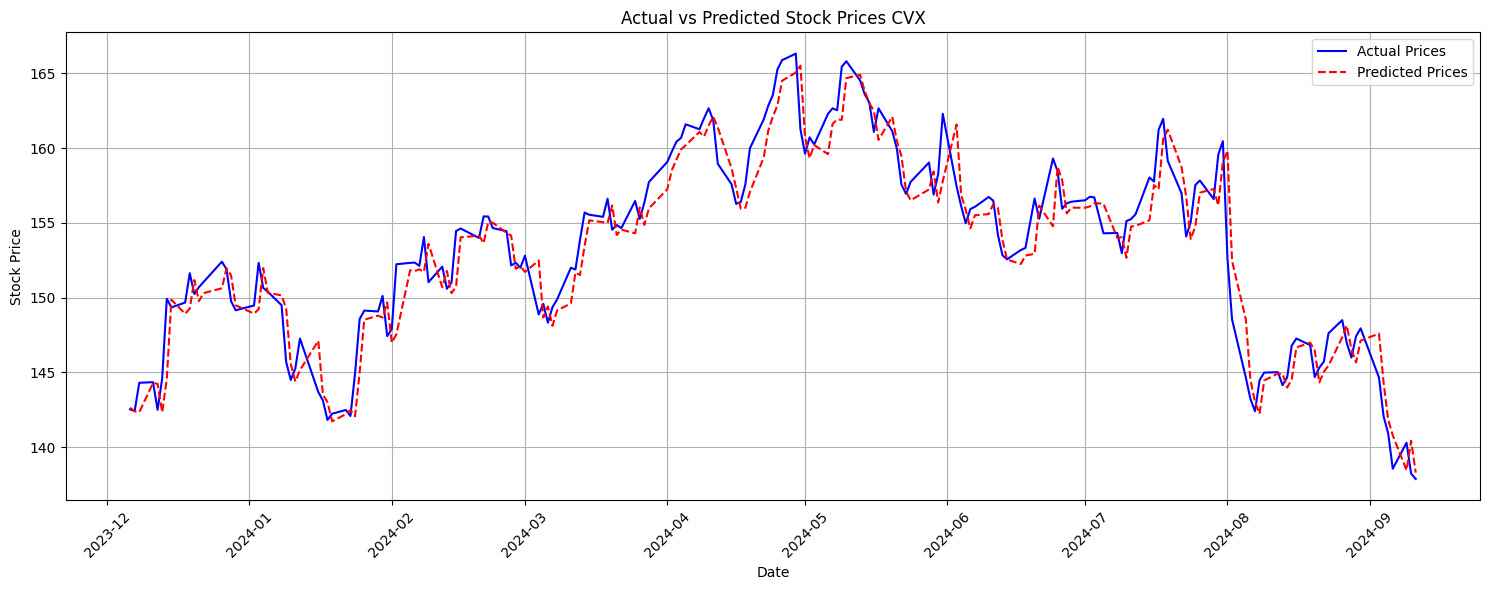

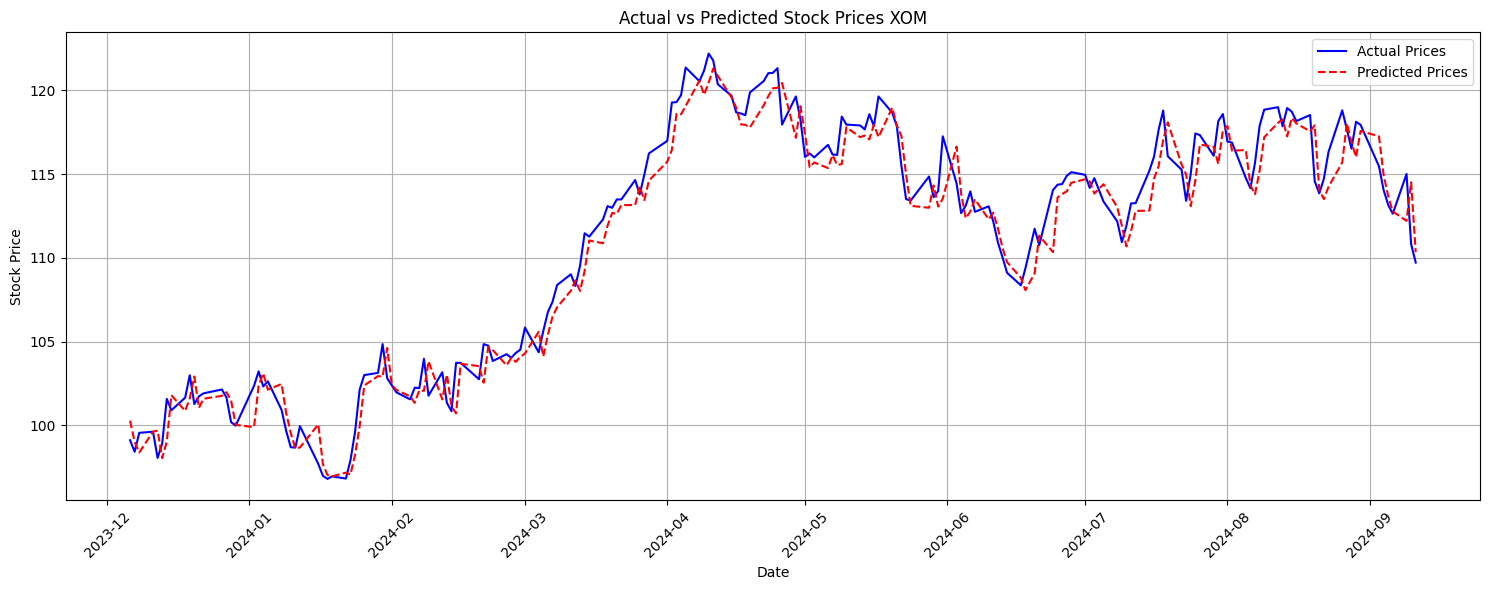

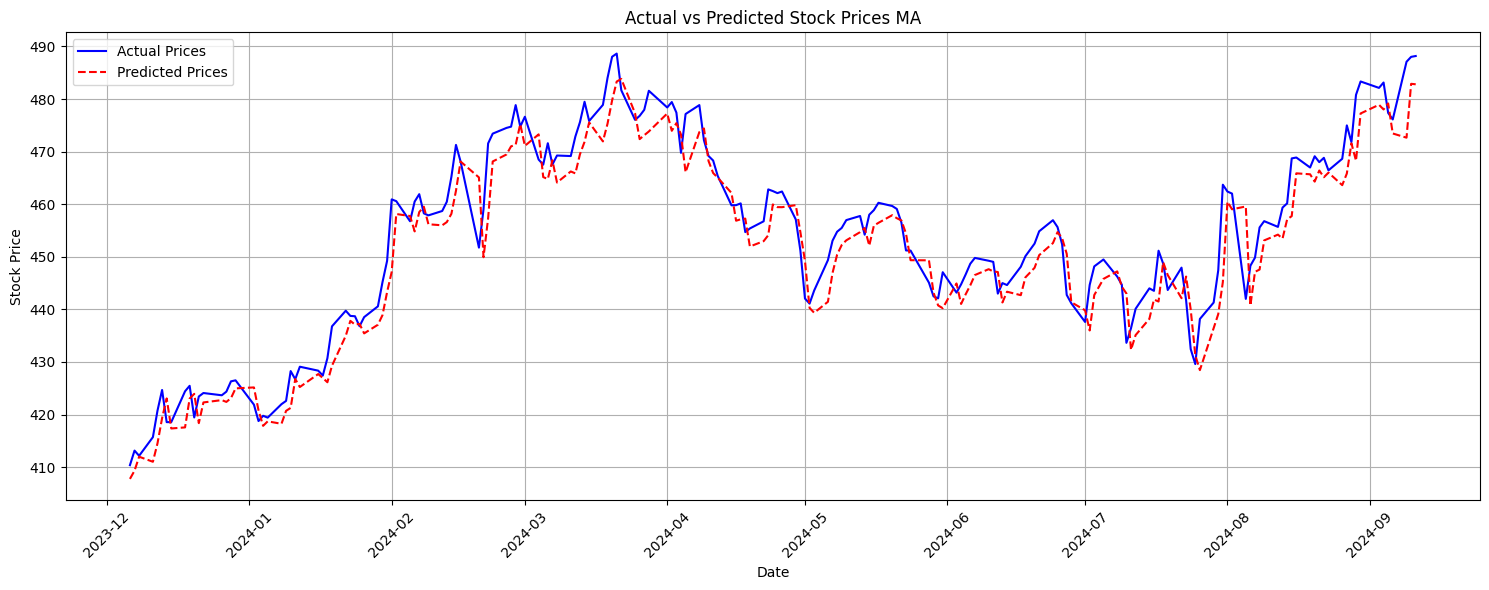

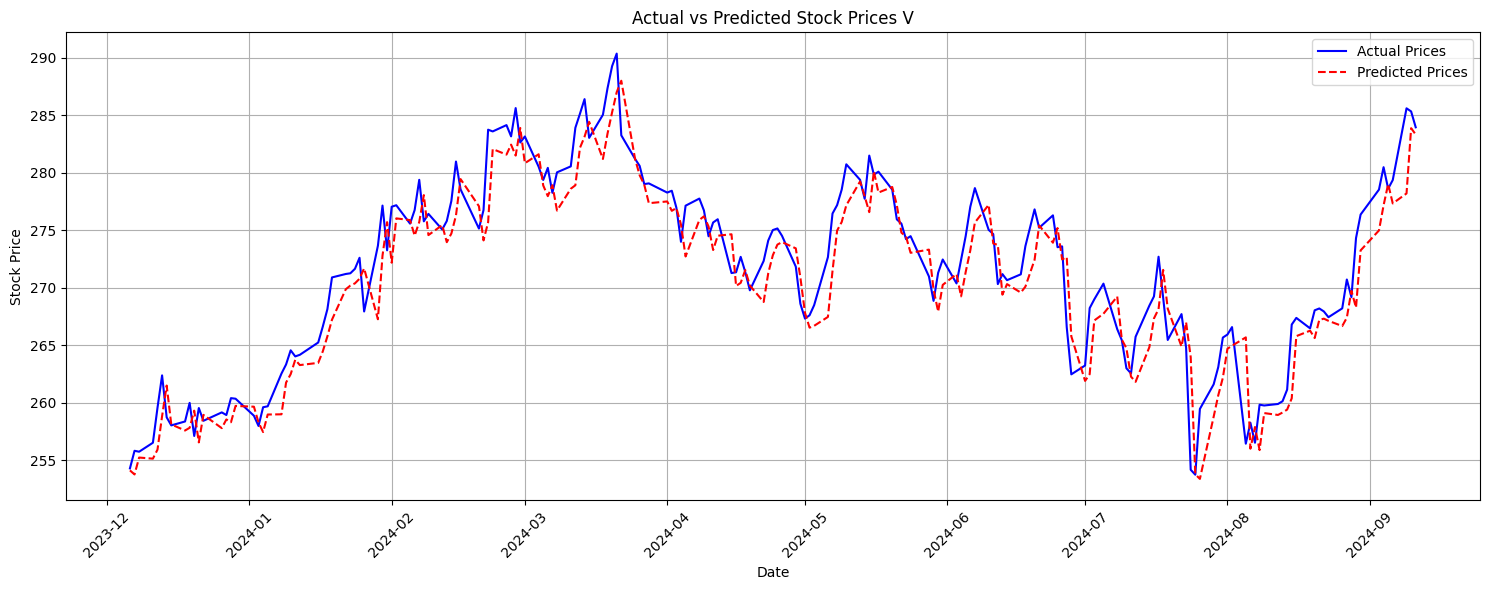

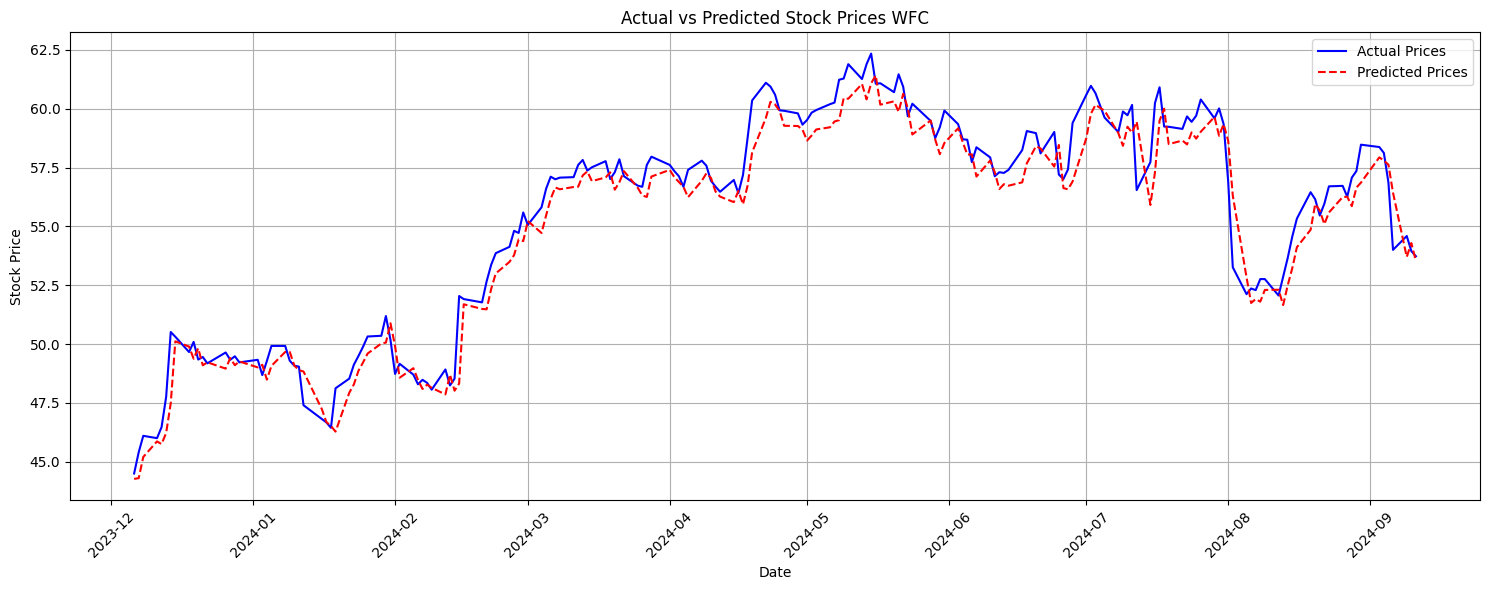

In [135]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for company in companies:
  specific_company_predictions = pd.DataFrame(predictions)[companies.index(company)]
  plot_results(data[[company]], specific_company_predictions, window_size, company)